<a href="https://colab.research.google.com/github/jessicamila05/analise_sendimentos_tweets_ti/blob/main/Class_sentimentos_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports...**



In [ ]:
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from PIL import Image
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from nltk import word_tokenize
from wordcloud import WordCloud,  ImageColorGenerator, STOPWORDS
from sklearn.pipeline import Pipeline
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline




In [ ]:
nltk.download("all")


**Lendo database**





In [ ]:
df_Tweets = pd.read_csv('drive/MyDrive/Classific_sentimentos/tweets.csv', encoding='utf-8')

In [ ]:
df_Tweets.TweetText.count()

5531

In [ ]:
print(df_Tweets.Sentimentos.value_counts())

neutro      2484
positivo    1546
negativo    1501
Name: Sentimentos, dtype: int64


**Remolvendo linhas duplicadas....**

In [ ]:
df_Tweets.drop_duplicates(['TweetText'], inplace=True)

In [ ]:
df_Tweets.TweetText.count()

4278

In [ ]:
print(df_Tweets.Sentimentos.value_counts())

neutro      1811
negativo    1236
positivo    1231
Name: Sentimentos, dtype: int64


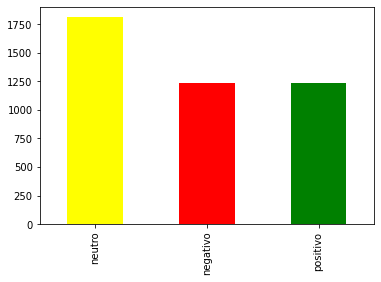

In [ ]:
df_Tweets.Sentimentos.value_counts().plot(kind='bar', color=["yellow", "red", "green"])

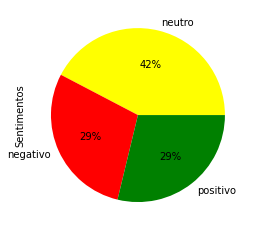

In [ ]:
df_Tweets.Sentimentos.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["yellow","red", "green"])

**Classes para separar texto e classificação de sentimentos.** 

In [ ]:
tweets = df_Tweets['TweetText'].values
classes = df_Tweets['Sentimentos'].values

**Removendo Stopwords e caracteres indesejados...**

In [ ]:
def Preprocessing(instancia):
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','').replace('"','')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

**Aplicando a função na base de dados...**

In [ ]:
tweets = [Preprocessing(i) for i in tweets]

In [ ]:
tweets[:10]

In [ ]:
df_Tweets["texto_tratado"] = tweets

**Iniciando treinamento do modelo (Bag of Words, Naive Bayes Multinomial)**

In [ ]:
vectorizer = CountVectorizer(analyzer="word")
freq_tweets = vectorizer.fit_transform(tweets)
modelo = MultinomialNB()
modelo.fit(freq_tweets,classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
testes = ['Edna sabino. professora de química, ela dança, ela canta, ela toca instrumentos, ela joga. ela é uma mulher brilhante, inteligente e muito linda. ela atualmente trabalha em um projeto que une as mulheres na tecnologia.ela é uma mulher que me inspira.',
          'Uma empresa que tenho vontade de trampar é na google. Estudar programação é muito caro,e dois cursos que mais me agregou na área, a google que patrocinou,acho foda que eles investem na tecnologia. Imagina ser desenvolvedora na google?! ',
          'Cadê as mulheres falando de ciência e tecnologia na internet? ',
          'ja é um pedaço dificil, nao quero nem SONHAR em ter que mexer com javascript']

In [ ]:
freq_testes = vectorizer.transform(testes)

In [ ]:
modelo.predict(freq_testes)

array(['positivo', 'positivo', 'neutro', 'negativo'], dtype='<U8')

**Ultilizando validação cruzada(Cross Validation)**

In [ ]:
resultados = cross_val_predict(modelo, freq_tweets, classes, cv=10)

**Acurácia Validação Cruzada...**

In [ ]:
metrics.accuracy_score(classes,resultados)

0.4340813464235624

**Medindo a Precisão, Revocação e Medida F do modelo**

In [ ]:
sentimento=['positivo','negativo','neutro']
print (metrics.classification_report(classes,resultados,sentimento),'')

              precision    recall  f1-score   support

    positivo       0.34      0.42      0.38      1231
    negativo       0.41      0.40      0.41      1236
      neutro       0.54      0.46      0.50      1811

    accuracy                           0.43      4278
   macro avg       0.43      0.43      0.43      4278
weighted avg       0.45      0.43      0.44      4278
 


**Gerando Matriz da confuzão** 

In [ ]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True), '')

Predito   negativo  neutro  positivo   All
Real                                      
negativo       499     332       405  1236
neutro         390     839       582  1811
positivo       325     387       519  1231
All           1214    1558      1506  4278 


**Melhorando o modelo de treinamento ultilizando o Bigrames**

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,2))
freq_tweets = vectorizer.fit_transform(tweets)
modelo = MultinomialNB()
modelo.fit(freq_tweets, classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
resultados = cross_val_predict(modelo, freq_tweets,classes, cv=10)
metrics.accuracy_score(classes,resultados)

0.3849929873772791

In [ ]:
print (pd.crosstab(classes, resultados, rownames=['Real'], colnames=['Predito'], margins=True))

Predito   negativo  neutro  positivo   All
Real                                      
negativo       455     290       491  1236
neutro         475     673       663  1811
positivo       393     319       519  1231
All           1323    1282      1673  4278


**Word Cloud...**

In [ ]:
%matplotlib inline
todas_palavras = ' '.join([texto for texto in df_Tweets.TweetText])
nuvem_palavras = WordCloud(width=800, height=500,
                           max_font_size = 110,
                           background_color="white",
                           collocations = False).generate(todas_palavras)

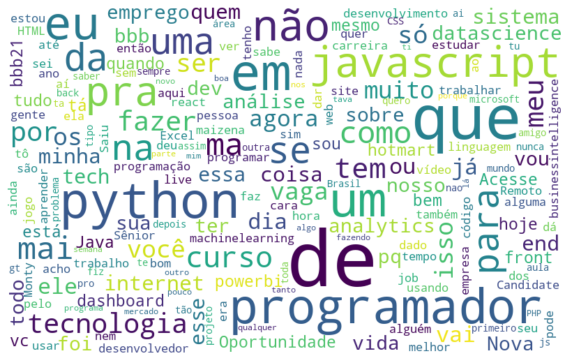

In [ ]:
plt.figure(figsize=(10,7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis("off")
plt.show()

**Word Cloud - Negativo**

In [ ]:
def nuvem_palavras_neg(texto, coluna_TweetText): 
  mascara_Word = np.array(Image.open("drive/MyDrive/Classific_sentimentos/mascara_wordCloud.jpg"))
  texto_negativo = texto.query("Sentimentos == 'negativo' ")
  todas_palavras = ' '.join([texto for texto in texto_negativo[coluna_TweetText]])

 
  nuvem_palavras = WordCloud(mask=mascara_Word,
                              colormap='Reds',
                            width=800, height=500,
                            max_font_size = 110,
                            collocations = False).generate(todas_palavras)
  plt.figure(figsize=(10,7))
  plt.imshow(nuvem_palavras, interpolation='bilinear')
  fig, ax = plt.subplots(figsize=(16,8))            
  plt.axis("off")
  plt.show()

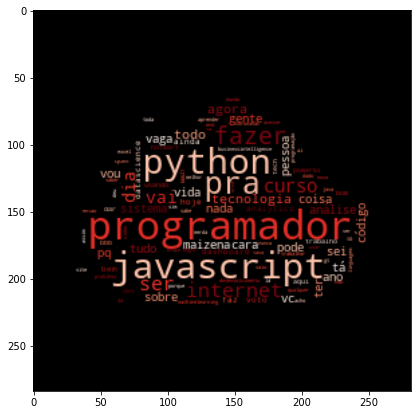

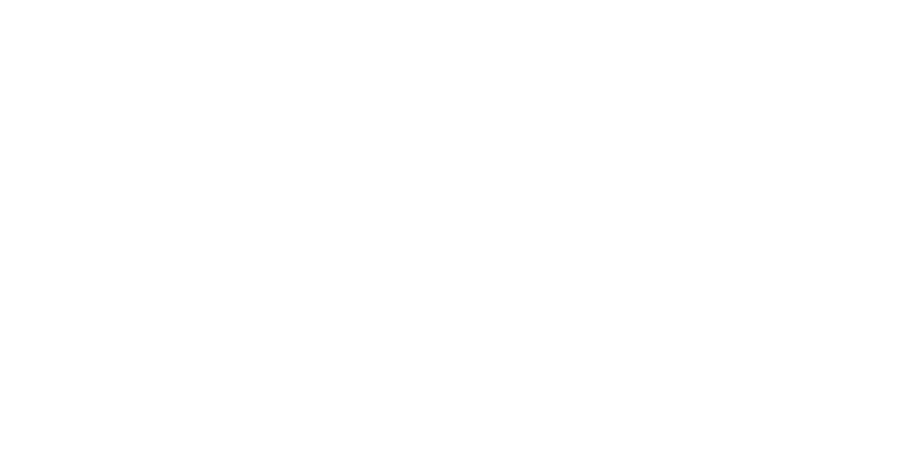

In [ ]:
nuvem_palavras_neg(df_Tweets, "texto_tratado")

In [ ]:
def nuvem_palavras_pos(texto, coluna_TweetText): 
  mascara_Word = np.array(Image.open("drive/MyDrive/Classific_sentimentos/mascara_wordCloud.jpg"))
  texto_positivo = texto.query("Sentimentos == 'positivo' ")
  todas_palavras = ' '.join([texto for texto in texto_positivo[coluna_TweetText]])

 
  nuvem_palavras = WordCloud( mask=mascara_Word,
                              colormap='Greens',
                              width=800, height=500,
                              max_font_size = 110,
                              collocations = False).generate(todas_palavras)
  plt.figure(figsize=(10,7))
  plt.imshow(nuvem_palavras, interpolation='bilinear')
  fig, ax = plt.subplots(figsize=(16,8))            
  plt.axis("off")
  plt.show()

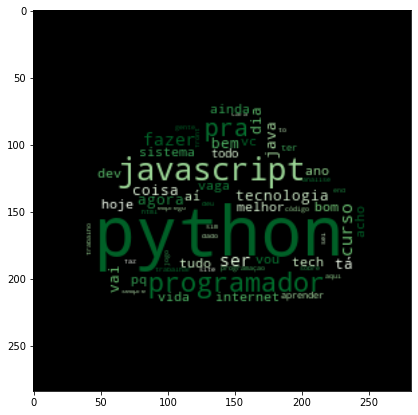

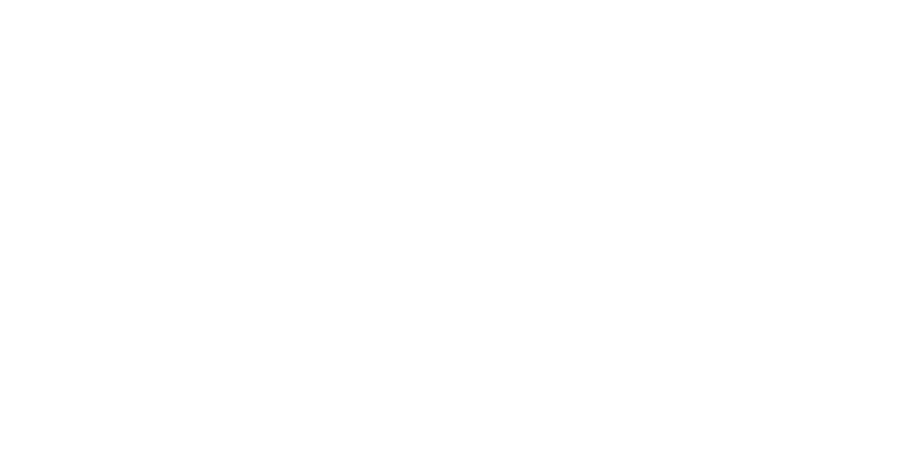

In [ ]:
nuvem_palavras_pos(df_Tweets, "texto_tratado")